In [411]:
import os
import gsw as gsw
import glob
import numpy as np
import netCDF4 as nc
import xarray as xr
import datetime
import time
import numpy.matlib
import matplotlib.ticker as mticker
from pylab import *
from mpl_toolkits.basemap import Basemap
#distance
from pyproj import Geod
geod = Geod(ellps='WGS84')

In [412]:
from tqdm import tqdm_notebook

## First open raw section data files to be interpolated

In [425]:
yr = '2012'
listfile=glob.glob('./ovide/'+yr+'/*.nc')
print listfile[0]
if int(yr) >= 2006:
    listfile.sort(reverse=True)
else:
    listfile.sort()
seclen = len(listfile)
month =  filedat[0].split('_')[0][21:23]
print month
print seclen
print listfile

./ovide/2012/29AH20120623_00095_00001_hy1.nc
06
60
['./ovide/2012/29AH20120623_00095_00001_hy1.nc', './ovide/2012/29AH20120623_00094_00001_hy1.nc', './ovide/2012/29AH20120623_00093_00001_hy1.nc', './ovide/2012/29AH20120623_00092_00001_hy1.nc', './ovide/2012/29AH20120623_00091_00001_hy1.nc', './ovide/2012/29AH20120623_00090_00001_hy1.nc', './ovide/2012/29AH20120623_00089_00001_hy1.nc', './ovide/2012/29AH20120623_00088_00001_hy1.nc', './ovide/2012/29AH20120623_00087_00001_hy1.nc', './ovide/2012/29AH20120623_00086_00001_hy1.nc', './ovide/2012/29AH20120623_00085_00001_hy1.nc', './ovide/2012/29AH20120623_00084_00001_hy1.nc', './ovide/2012/29AH20120623_00083_00001_hy1.nc', './ovide/2012/29AH20120623_00082_00001_hy1.nc', './ovide/2012/29AH20120623_00081_00001_hy1.nc', './ovide/2012/29AH20120623_00080_00001_hy1.nc', './ovide/2012/29AH20120623_00079_00001_hy1.nc', './ovide/2012/29AH20120623_00078_00001_hy1.nc', './ovide/2012/29AH20120623_00077_00001_hy1.nc', './ovide/2012/29AH20120623_00076_000

In [420]:
vol = 28
tempOV=np.zeros((seclen,vol))
saltOV=np.zeros((seclen,vol))
depthOV=np.zeros((seclen,vol))
latOV=np.zeros(seclen)
lonOV=np.zeros(seclen)

## Now we prepare the data to be stored on the 2d grid

In [438]:
for t in np.arange(seclen):
    file_OVIDE=listfile[t]
    print file_OVIDE
    ds = xr.open_dataset(file_OVIDE)
    latOV[t]=ds.latitude.values
    lonOV[t]=ds.longitude.values
    if len(ds.pressure.values) < vol:
        l=len(ds.pressure.values)
        tempOV[t,0:l]=ds.temperature.values
        saltOV[t,0:l]=ds.salinity.values
        depthOV[t,0:l]=gsw.conversions.z_from_p(ds.pressure.values, ds.latitude.values)
    else:
        tempOV[t,:]=ds.temperature.values
        saltOV[t,:]=ds.salinity.values
        depthOV[t,:]=gsw.conversions.z_from_p(ds.pressure.values, ds.latitude.values)

./ovide/2012/29AH20120623_00095_00001_hy1.nc
./ovide/2012/29AH20120623_00094_00001_hy1.nc
./ovide/2012/29AH20120623_00093_00001_hy1.nc
./ovide/2012/29AH20120623_00092_00001_hy1.nc
./ovide/2012/29AH20120623_00091_00001_hy1.nc
./ovide/2012/29AH20120623_00090_00001_hy1.nc
./ovide/2012/29AH20120623_00089_00001_hy1.nc
./ovide/2012/29AH20120623_00088_00001_hy1.nc
./ovide/2012/29AH20120623_00087_00001_hy1.nc
./ovide/2012/29AH20120623_00086_00001_hy1.nc
./ovide/2012/29AH20120623_00085_00001_hy1.nc
./ovide/2012/29AH20120623_00084_00001_hy1.nc
./ovide/2012/29AH20120623_00083_00001_hy1.nc
./ovide/2012/29AH20120623_00082_00001_hy1.nc
./ovide/2012/29AH20120623_00081_00001_hy1.nc
./ovide/2012/29AH20120623_00080_00001_hy1.nc
./ovide/2012/29AH20120623_00079_00001_hy1.nc
./ovide/2012/29AH20120623_00078_00001_hy1.nc
./ovide/2012/29AH20120623_00077_00001_hy1.nc
./ovide/2012/29AH20120623_00076_00001_hy1.nc
./ovide/2012/29AH20120623_00075_00001_hy1.nc
./ovide/2012/29AH20120623_00074_00001_hy1.nc
./ovide/20

In [439]:
depthOV = depthOV*-1

## Now, read the target section grid and any variable, to define where the section exists. 

In [440]:
secfile = './ovide/NNATLYS12-V1_m01_ovide.nc'
secdat = xr.open_dataset(secfile)
lat=np.squeeze(secdat.nav_lat.values)
lon=np.squeeze(secdat.nav_lon.values)
temp=np.squeeze(secdat.votemper.values)
dep=np.squeeze(secdat.deptht.values)
print temp.shape

(23, 50, 436)


## Define mask - now they all are masked arrays, so we can use it in order to not to compute distances to the masked points

In [441]:
tempOV_mask=ma.masked_where(tempOV==0.,tempOV)
saltOV_mask=ma.masked_where(saltOV==0.,saltOV)

temp_mask=ma.masked_where(temp==0.,temp)
print tempOV_mask.shape

(60, 28)


## Compute distances for X1 (raw data) and X2 (gridded data)

In [442]:
distOV=np.zeros(seclen)
# distOV - distance between stations in meters
distOV[0]=0
for i in np.arange(1,seclen):
    az1,az2,dist=geod.inv(lonOV[i-1],latOV[i-1],lonOV[i],latOV[i])
    distOV[i]=distOV[i-1]+dist
#print distOV

In [443]:
dist=np.zeros(len(lat))
dist[0]=0
for i in np.arange(1,len(lat)):
    az1,az2,distg=geod.inv(lon[i-1],lat[i-1],lon[i],lat[i])
    dist[i]=dist[i-1]+distg
dist[-1] = dist[-2]+30
#print dist

## Now we have to compute distance between first points of X1 and X2

In [444]:
az1,az2,diff = geod.inv(lon[0], lat[0], lonOV[0], latOV[0])
print lon[0], lat[0], lonOV[0], latOV[0]
print diff

-42.8618 59.8713 -42.6155014038 59.8460998535
14086.6594765


### Let the model grid to be the reference 0:
If the |lon| > |lonOV| then X2dist+diff
Else: X2dist-diff (multiply by -1)

In [445]:
if np.absolute(lon[0]) > np.absolute(lonOV[0]):
    distOVnew = distOV+diff
else:
    distOVnew = distOV-diff
print len(distOVnew)

ddist=np.matlib.repmat(distOVnew,vol,1)
print ddist.shape

60
(28, 60)


# Lets summarize: 
Target grid starts at 0,0. It has 50 vertical levels and 436 points along the section. Source grid has 1368 or less vertical points and 75 points along the section. 
Except the vertical spacing of the vertical grid, all the distances are spaced evenly. 
So what we do is we flatten all arrays:
- source grid is reduced to the number of points only covered by data and flattened.
- target grid still have nan, which is the key to the back reverting. 

In [446]:
yyp=ddist[:,0:90]
depthp=depthOV[0:90,:]
tempp=tempOV_mask[0:90,:]
saltp=saltOV_mask[0:90,:]
latp=latOV[0:90]
distp=distOV[0:90]

In [447]:
# Make the arrays flatten and equal for sg
dp = depthp.flatten()
ddist = yyp.T
dd = ddist.flatten()
tt = tempp.flatten()
ss = saltp.flatten()
print tt.shape, dd.shape
dist_f = dd[~tt.mask]
dep_f = dp[~tt.mask]
salt_f = ss[~tt.mask]
temp_f = tt[~tt.mask]
print dist_f.shape, dep_f.shape
print dep_f.max()
print ddist.shape, tempp.shape, depthp.shape

# # Make the arrays flatten and equal for sg
# dp = depthOV.flatten()
# ddist = ddist.T
# dd = ddist.flatten()
# tt = tempOV_mask.flatten()
# ss = saltOV_mask.flatten()
# print tt.shape, dd.shape
# dist_f = dd[~tt.mask]
# dep_f = dp[~tt.mask]
# salt_f = ss[~tt.mask]
# temp_f = tt[~tt.mask]
# print dist_f.shape, dep_f.shape
# print dep_f.max()
# print ddist.shape, tempOV_mask.shape, depthOV.shape

(1680,) (1680,)
(1439,) (1439,)
4441.00589921
(60, 28) (60, 28) (60, 28)


In [448]:
# Make a flatten array for model data
mdep = np.matlib.repmat(dep,len(dist),1).T
mdist=np.matlib.repmat(dist,len(dep),1)
print mdep.shape, mdist.shape
mp = mdep.flatten()
md = mdist.flatten()
mt = temp_mask[0].flatten()
print mp.shape, md.shape, mt.shape
print mp.max()

(50, 436) (50, 436)
(21800,) (21800,) (21800,)
5727.92


## For each dataset we have to correctly define the kx, ky

In [449]:
# X-axis distances
xdiff = []
for i in range(len(lat)):
    #print dist[i]
    xd = distOV - dist[i]
    xdiff.append(xd)

# Y-axis distances
ydiff = []
for i in range(len(dep)):
    yd = dep_f - dep[i]
    ydiff.append(yd)

kx = 200/(np.std(xdiff))**2
ky = 600/(np.std(ydiff))**2

## Here is the start of the main loop

In [450]:
# Start the main loop
t_fin = np.zeros(len(mp))
s_fin = np.zeros(len(mp))
for i in tqdm_notebook(range(len(mp)), total=len(mp)):
    if np.isnan(mt[i])==False:
        xdiff = dist_f - md[i] # md - model dist, dist_f - sg dist
        ydiff = dep_f - mp[i] # mp - model depth, dep_f - sg depth
        wght = np.exp(-kx*(xdiff**2)-ky*(ydiff**2))
        #w_mask = (wght >= np.sort(wght)[-32])
        w_mask = (wght >= 0.1)
        w_filt = wght[w_mask]
        t_filt = temp_f[w_mask]
        s_filt = salt_f[w_mask]
        w_norm = w_filt/(w_filt.sum())
        t_fin[i] = (t_filt*w_norm).sum()
        s_fin[i] = (s_filt*w_norm).sum()

In [451]:
tt_fin = np.reshape(t_fin,(50,436))
ss_fin = np.reshape(s_fin,(50,436))
tt_mask=ma.masked_where(tt_fin==0.,tt_fin)
ss_mask=ma.masked_where(ss_fin==0.,ss_fin)

In [452]:
binsf=np.arange(0,16,0.1)
binss=np.arange(34.6,36,0.01)
dmax=4500
strlon = [40,5]
strpos = [[150,3400],[2090,3400]]
key = 1

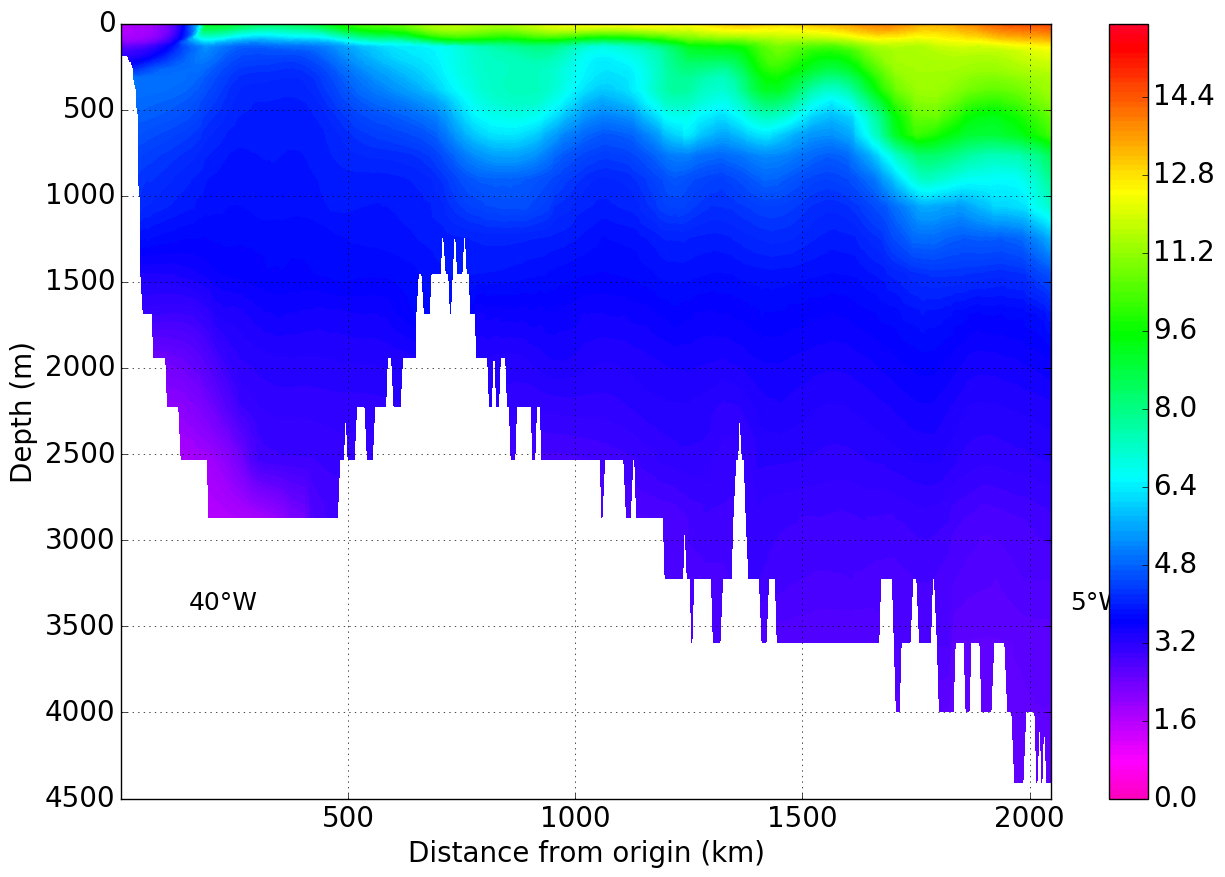

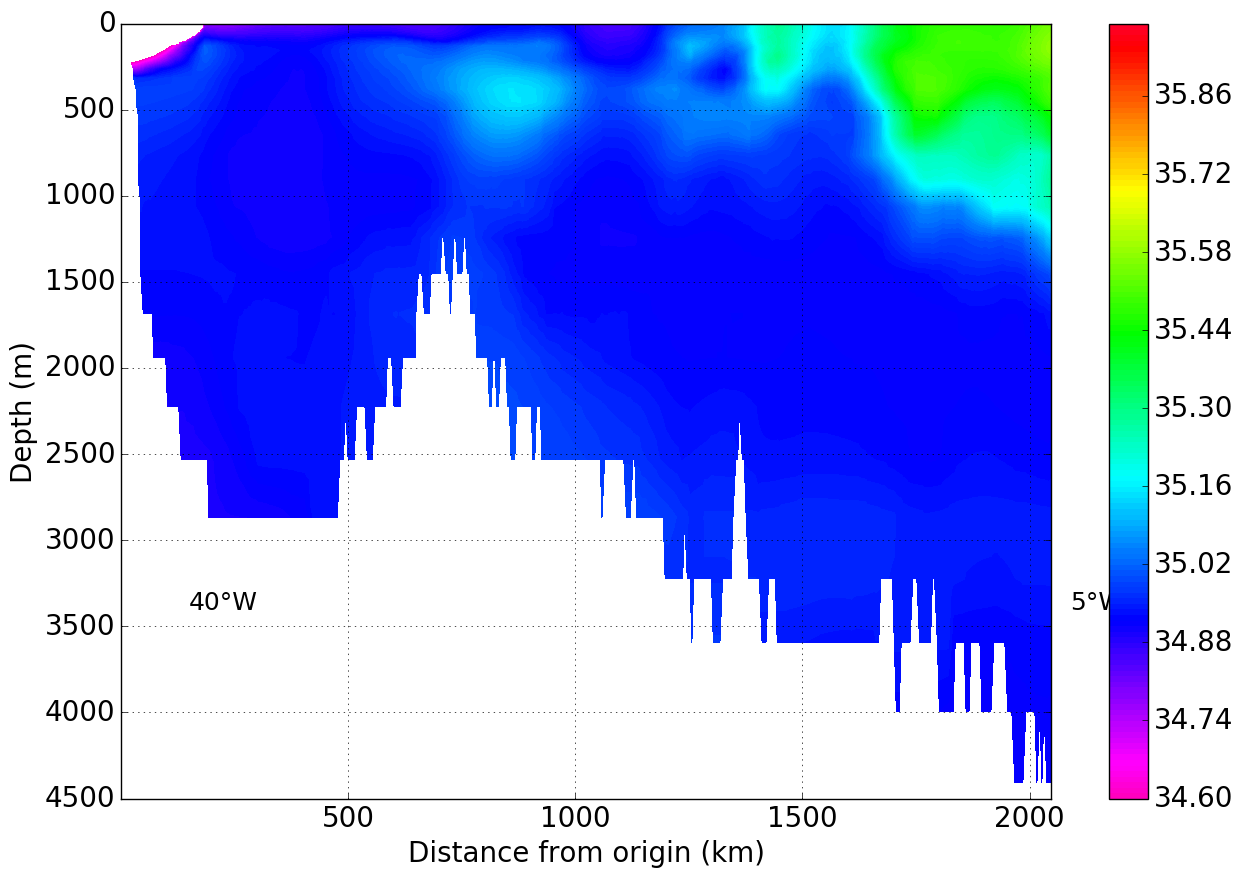

In [453]:
varbs = [tt_mask, ss_mask]
bins = [binsf, binss]
names = ['Temperature','Salinity']
idx = ['temp', 'salt']
for i in range(2):
    fig = plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    pcolor=plt.contourf(1e-3*dist,dep,varbs[i],bins[i],cmap='gist_rainbow_r')
    #pcolor=plt.contour(1e-3*dist,dep,varbs[i],bins[i],colors='k')
    ax.set_ylabel('Depth (m)',fontsize=20)
    ax.set_xlabel('Distance from origin (km)',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_ylim([dmax,0])
    plt.text(strpos[0][0],strpos[0][1],str(strlon[0])+u'\N{DEGREE SIGN}W',fontsize=18);
    plt.text(strpos[1][0],strpos[1][1],str(strlon[1])+u'\N{DEGREE SIGN}W',fontsize=18);
    tick_locations=np.array([500,1000,1500,2000,2500,3000])
    ax.xaxis.set_major_locator(mticker.FixedLocator(tick_locations))
    ax.grid(True)
    cbar=plt.colorbar(pcolor)
    cbar.ax.tick_params(labelsize=20)
    #plt.title(names[i]+' '+secn+' '+mont,fontsize=20)
    plt.show()

## Here we create and write the NetCDF file with the interpolated section

In [454]:
# output netcdf file creation
section = nc.Dataset('./OVN_'+yr+'.nc', 'w', format='NETCDF4_CLASSIC')
# create dimensions
xax = section.createDimension('xax',436)
yax = section.createDimension('yax',436)
zax = section.createDimension('zax',50)
tax = section.createDimension('time',None)

# create varibles for 3d value
nav_lat = section.createVariable('nav_lat', np.int32,('xax',))
nav_lon = section.createVariable('nav_lon', np.int32,('yax',))
deptht = section.createVariable('deptht', np.int32,('zax',))
time_counter = section.createVariable('time_counter',int32,('time',))
votemper = section.createVariable('votemper', np.float32,('time','zax','xax'))
vosaline = section.createVariable('vosaline', np.float32,('time','zax','xax'))
# create attributes
section.description = 'OVIDE section interpolated on the NNATL12-MPX OVIDE section subsample'
section.history = 'Created '+time.ctime(time.time())
section.source = 'OVIDE section observations from: '+filedat[0]
# create variables attributes
time_counter.units = 'time in YYYY format'
nav_lat.units = 'latitude'
nav_lon.units = 'longitude'
deptht.units = 'depth in meters'
votemper.units = 'K degrees'
vosaline.units = 'PSU'

print votemper.shape

xax = np.arange(0,436,1)
yax = np.arange(0,436,1)
zax = np.arange(0,50,1)
nav_lat[:] = lat[:]
nav_lon[:] = lon[:]
deptht[:] = dep[:]
time_counter[:] = int(yr)
votemper[0,:,:] = tt_mask[:,:]
vosaline[0,:,:] = ss_mask[:,:]
section.close()

(0, 50, 436)


## Before we do the essential things, we get kx, ky on the regular grid the grid is done in meters with regular spacing

In [455]:
xx = np.arange(0,2400000,20000)
yy = np.arange(0,6000,50)
xm, ym = np.meshgrid(xx,yy)
print xx.shape, yy.shape

(120,) (120,)


In [456]:
# X-axis distances
#xdiff = np.zeros(len(seclen))
xdiff = []
for i in range(len(lat)):
    #print dist[i]
    xd = xx - dist[i]
    xdiff.append(xd)
#print xdiff[320]

In [457]:
# Y-axis distances
ydiff = []
for i in range(len(dep)):
    yd = yy - dep[i]
    ydiff.append(yd)

In [458]:
xdiff = np.asarray(xdiff)
ydiff = np.asarray(ydiff)
print xdiff.shape, ydiff.shape
print np.std(xdiff), np.std(ydiff)

(436, 120) (50, 120)
907592.76067 2336.27381208


In [459]:
wght = np.zeros((len(xx),len(yy)))
#kx = 120/(np.std(xdiff))**2
#ky = 1OV/(np.std(ydiff))**2
print kx, ky
for i in range(len(xx)):
    for j in range(len(yy)):
        wght[i,j] = np.exp(-kx*(xdiff[200,j]**2)-ky*(ydiff[34,i]**2))
        #print wght[i,j]

2.48143879125e-10 0.000173575225169


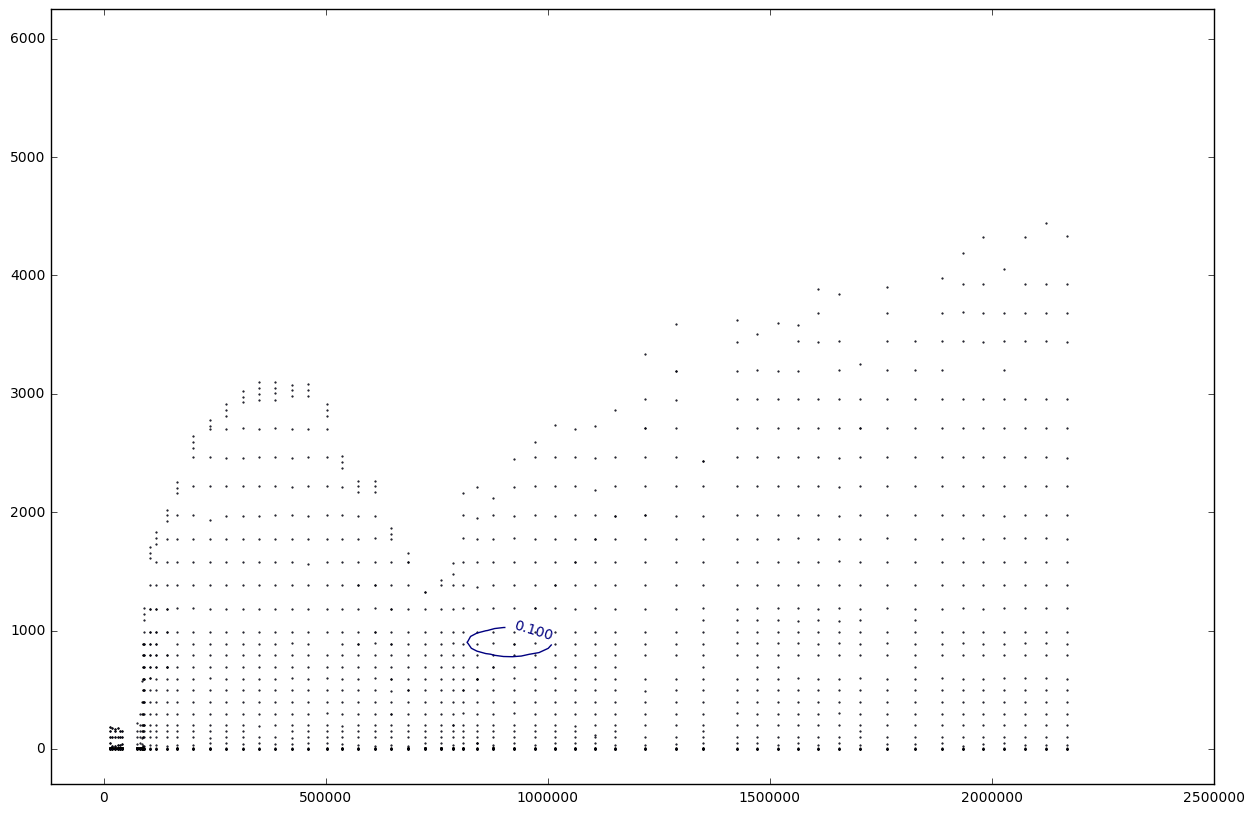

In [460]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
clevs = [0.1]
CS = plt.contour(xx,yy,wght,clevs)
SC = plt.scatter(yyp.T,depthOV,s=0.3)
ax.clabel(CS, inline=1, fontsize=10)
plt.show()